<a href="https://colab.research.google.com/github/irenedini/learning-fastai/blob/main/multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 2.6MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 1.0MB 9.7MB/s 
     |████████████████████████████████| 194kB 18.5MB/s 
     |████████████████████████████████| 40kB 5.8MB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 2.6MB 15.5MB/s 
Mounted at /content/gdrive


In [4]:
from fastbook import *
from fastai.vision import *
import pandas as pd

In [3]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train')]

In [6]:
df = pd.read_csv(path/'train.csv')
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


In [33]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].to_list()
    validation = df.index[df['is_valid']].to_list()
    return train, validation

In [45]:
db = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=RandomResizedCrop(size=224, min_scale=0.35)
)

In [46]:
ds = db.datasets(df)

for i in range(5):
    print(ds.train[i])

(PILImage mode=RGB size=500x333, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(PILImage mode=RGB size=480x364, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]))
(PILImage mode=RGB size=334x500, TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))
(PILImage mode=RGB size=500x333, TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
(PILImage mode=RGB size=500x281, TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))


In [44]:
dls = db.dataloaders(df)

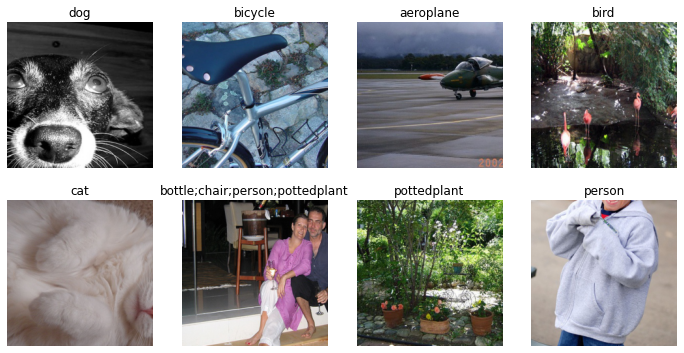

In [47]:
dls.show_batch(nrows=2, ncols=4)

In [56]:
def multilabel_accuracy(pred, targ, treshold=0.5, sigmoid=True):
    if sigmoid: pred = pred.sigmoid()
    return ((pred>treshold)==targ.bool()).float().mean()

In [57]:
learner = cnn_learner(dls, resnet34, metrics=multilabel_accuracy)

In [58]:
learner.fine_tune(4, freeze_epochs=2)

epoch,train_loss,valid_loss,multilabel_accuracy,time
0,0.965979,0.686060,0.622410,00:56
1,0.775337,0.401205,0.859701,00:57


epoch,train_loss,valid_loss,multilabel_accuracy,time
0,0.456800,0.288184,0.934522,01:11
1,0.331243,0.148762,0.967649,01:12
2,0.237030,0.113103,0.969661,01:10
3,0.186605,0.109012,0.970597,01:11


In [63]:
learner.metrics = partial(multilabel_accuracy, treshold=0.3)
learner.validate()

(#2) [0.10901150107383728,0.9644025564193726]

In [64]:
preds, targs = learner.get_preds()

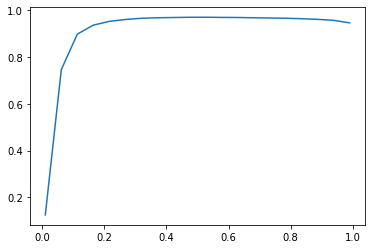

In [66]:
tr = torch.linspace(0.01, 0.99, 20)
accs = [multilabel_accuracy(preds, targs, treshold=i, sigmoid=False) for i in tr]

plt.plot(tr, accs)